# 基于“货币-信用”状态的BL资产配置模型

用模拟组合，在无卖空条件下，分别实现马科维茨模型的配置结果，和包含“货币-信用”观点的Black-Litterman模型配置结果。
## 设定组合资产
价值股:国证价值指数  399371.SZ
成长股:国证成长指数  399370.SZ
无风险资产：10Y国债收益率
## 均值方差模型下的市场最大化夏普配置结果
## 市场均衡收益率下的BL模型配置结果


In [35]:
### 数据库导入
from iFinDPy import *
from datetime import datetime
import pandas as pd
import time as _time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
### 同花顺登陆
user_name,password = ["hacb201","976306"]
def thslogindemo(us,psw):
    # 输入用户的帐号和密码
    thsLogin = THS_iFinDLogin(us,psw)
    print(thsLogin)
    if thsLogin != 0:
        print('登录失败')
    else:
        print('登录成功')

thslogindemo(user_name,password)

0
登录成功


In [6]:
### 抓取数据及数据清洗
index_list = ['399370.SZ,399371.SZ']
data_js = THS_DS(index_list,'ths_close_price_index;ths_chg_ratio_index',';','block:history','2012-01-01','2022-12-31')
data_df = data_js.data
print(data_df.head(1),sum(data_df.ths_chg_ratio_index.isna()))


         time    thscode  ths_close_price_index  ths_chg_ratio_index
0  2018-03-16  399370.SZ                4256.07            -1.160578 0


In [18]:
### 定义无风险收益率和tau

Goverment_bond_YTM_10Y = 0.0283
tau = 0.025

In [14]:
### 计算历史协方差矩阵、收益率均值向量
data_df_pivot = data_df.pivot(index='time',columns='thscode', values='ths_chg_ratio_index')
#print(data_df_pivot.tail(2))
Pi = data_df_pivot.mean()
sigma = data_df_pivot.cov()
print(Pi,sigma)

thscode
399370.SZ    0.017685
399371.SZ   -0.007463
dtype: float64 thscode    399370.SZ  399371.SZ
thscode                        
399370.SZ   2.297223   1.379362
399371.SZ   1.379362   1.454723


[1. 0.] -0.010614502213535815 1.5156591422772292
-0.026811306597249465
-0.02661090579564626
-0.02641050499404305
-0.026210104192439847
-0.026009703390836643
-0.025809302589233432
-0.02560890178763023
-0.025408500986027018
-0.025208100184423814
-0.02500769938282061
-0.0248072985812174
-0.024606897779614195
-0.02440649697801099
-0.02420609617640778
-0.024005695374804577
-0.023805294573201366
-0.023604893771598162
-0.02340449296999496
-0.023204092168391748
-0.023003691366788544
-0.02280329056518534
-0.02260288976358213
-0.022402488961978925
-0.02220208816037572
-0.02200168735877251
-0.021801286557169307
-0.021600885755566096
-0.021400484953962892
-0.02120008415235969
-0.020999683350756478
-0.020799282549153274
-0.020598881747550063
-0.02039848094594686
-0.020198080144343655
-0.019997679342740445
-0.01979727854113724
-0.019596877739534037
-0.019396476937930826
-0.019196076136327622
-0.01899567533472442
-0.018795274533121208
-0.018594873731518004
-0.018394472929914793
-0.01819407212831159
-

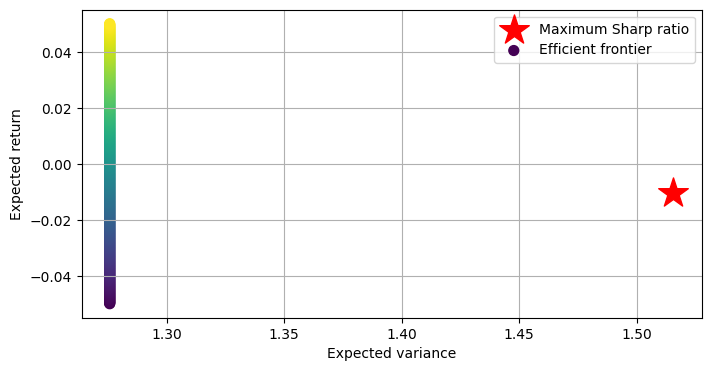

In [115]:
### 计算均值-方差模型得到最大夏普的市场权重
# 定义组合收益率和方差计算
def port_return(weights, returns, risk_free_date):
    return np.sum(weights * returns.mean(axis = 0))-risk_free_date

def port_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T,np.dot(returns.cov(), weights)))

# 定义目标函数
def sharp_ratio(weights, returns, risk_free_date):
    portfolio_return = np.sum(weights * returns.mean(axis = 0))
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(returns.cov(), weights)))
    sharp_ratio = (portfolio_return - risk_free_date) / portfolio_volatility
    return -sharp_ratio
# 定义最优化函数（拉格朗日乘子法），计算最大夏普
initial_weitghts = np.ones(len(data_df_pivot.columns),)/len(data_df_pivot.columns)
bounds = [(0,1)] * len(data_df_pivot.columns)
constraints = (
    {'type':'eq','fun': lambda x: np.sum(x)-1}, #eq表示等式约束，表示等于0
    {'type':'ineq','fun':lambda x:x} #ineq表示不等式约束，表示大于等0，对应禁止卖空
)
# 求解权重
result = minimize(sharp_ratio, initial_weitghts,args=(data_df_pivot,Goverment_bond_YTM_10Y), method='SLSQP',bounds=bounds, constraints=constraints)
print(result.x, port_return(result.x, data_df_pivot, Goverment_bond_YTM_10Y), port_volatility(result.x, data_df_pivot))
# 绘制有效前沿曲线
plt.figure(figsize=(8,4))
plt.scatter(port_volatility(result.x, data_df_pivot),port_return(result.x, data_df_pivot, Goverment_bond_YTM_10Y), marker='*', color='r', s=500,
            label='Maximum Sharp ratio')

target_returns = np.linspace(-0.050, 0.050, 500)
target_volatility = []

for tar in target_returns:
    constraints_for = (
    {'type':'eq','fun': lambda x: np.sum(x)-1}, #eq表示等式约束，表示等于0
    {'type':'eq','fun': lambda x: port_return(x, data_df_pivot, Goverment_bond_YTM_10Y)-x} #约束组合收益率等于tar。这样就可以得到在不同目标收益率下的最小方差
    )
    result_for = minimize(port_volatility,initial_weitghts,method='SLSQP',
                          bounds=bounds,
                          args=(data_df_pivot),
                          constraints=constraints_for)
    print(tar-port_return(result_for.x, data_df_pivot, Goverment_bond_YTM_10Y))
    target_volatility.append(result_for.fun)
target_volatility = np.array(target_volatility)
plt.scatter(target_volatility,target_returns,c=(target_returns-Goverment_bond_YTM_10Y)/target_volatility, s=50,
            label = 'Efficient frontier') # c: 散点的颜色，可以是一个标量或者一个数组，这里是target_returns/target_vars，表示每个散点的颜色由其夏普比率决定
plt.grid(True)
plt.xlabel('Expected variance')
plt.ylabel('Expected return')
plt.legend(loc='best')
plt.show()

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 假设有3个资产的历史日收益率数据
returns =pd.DataFrame(np.array([[0.01, 0.02, 0.03], [0.02, 0.03, 0.04], [0.03, 0.04, 0.05]]))

# 计算每个资产的日平均收益率
mean_returns = returns.mean()

# 计算协方差矩阵
cov_matrix = returns.cov()

# 定义目标函数，即负的夏普比率
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    port_return = np.sum(mean_returns * weights)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_std
    return -sharpe_ratio

# 定义约束条件
def check_sum(weights):
    return np.sum(weights) - 1

cons = ({'type':'eq', 'fun':check_sum})

bounds = ((0, 1), (0, 1), (0, 1))

# 假设无风险利率为0.01
risk_free_rate = 0.01

# 初始权重分配，均匀分配
init_guess = [0.33, 0.33, 0.33]

# 最优化求解最大夏普权重
result = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=cons)

# 输出结果
print(result)



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.999999999999999
       x: [ 0.000e+00  3.886e-16  1.000e+00]
     nit: 2
     jac: [ 1.000e+00  0.000e+00 -1.000e+00]
    nfev: 8
    njev: 2


-0.019866220734922967
-0.014777804462749199
-0.00969644680775617
-0.004629550881463485
1.355112307088735e-10
4.6813851406479756e-11
-7.830076864667745e-12
-6.247400513581525e-11
0.0008467969197459152
0.00606802545695443
0.01123111931454071
0.016370272680655704
0.021497258793510332
0.026617218459529454
0.031732753937127954
0.03684532368526453
0.04195580857906126
0.04706477207186096
0.052172591358995664
0.057279528461072655
0.06238577107590513
0.06749145717959226
0.07259669045879757
0.07770155036153462
0.08280609876860615
0.08791038460778258
0.09301444706006058
0.09811831790153962
0.10322202312617232
0.1083255842539873
0.11342901921211956
0.11853234309020541
0.12363556864708516
0.12873870677093105
0.13384176679534288
0.13894475677340118
0.14404768368336068
0.14915055361150853
0.1542533718772788
0.15935614317750693
0.1644588716300085
0.16956156089148974
0.17466421424706696
0.17976683457211642
0.1848694244732549
0.18997198629380468
0.19507452212950133
0.20017703388005317
0.2052795232547485

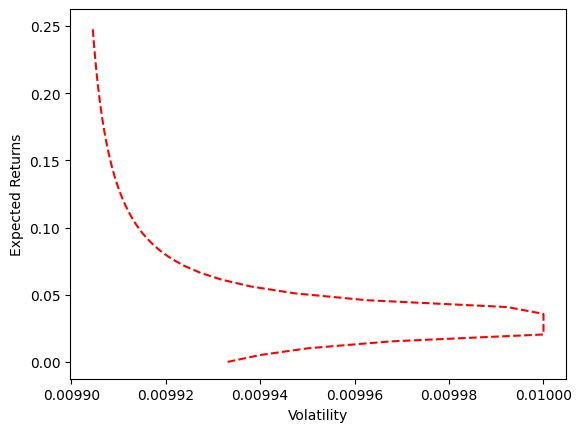

In [117]:
# 计算有效前沿曲线
def port_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

def port_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def neg_port_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -((port_return(weights, mean_returns) - risk_free_rate) / port_volatility(weights, cov_matrix))

def minimize_volatility(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(port_volatility, num_assets*[1./num_assets,], args=args,
                   method='SLSQP', bounds=bounds, constraints=constraints)
    return result

target_returns = np.linspace(0.0, 0.25, 50)
target_volatility = []
for tar in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: port_return(x, mean_returns) - tar},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(neg_port_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)
    target_volatility.append(port_volatility(result.x, cov_matrix))
    print(tar - port_return(result.x, mean_returns))

# 绘制有效前沿曲线
plt.plot(target_volatility, target_returns, 'r--')
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.show()

In [108]:
result.x

array([1., 0.])

'''
scipy.optimize.minimize函数的返回值，是一个OptimizeResult对象，包含了最优化过程的信息。最优化结果result有以下属性：

x: 最优解
success: 布尔值，表示是否成功找到最优解
status: 整数，表示最优化过程的状态码
message: 字符串，表示最优化过程的终止原因
fun: 浮点数，表示目标函数在最优解处的值
jac: 数组，表示目标函数在最优解处的梯度
hess: 矩阵或者线性算子，表示目标函数在最优解处的海森矩阵或者近似
nfev: 整数，表示目标函数被调用的次数
njev: 整数，表示梯度被调用的次数
nhev: 整数，表示海森矩阵被调用的次数
nit: 整数，表示迭代次数
'''

array([1., 0.])

In [ ]:
### 计算先验分布：市场均衡权重、均衡收益率、风险厌恶系数、假定τ





In [ ]:
### 设定市场观点。计算观点矩阵、观点收益率向量、观点协方差矩阵


In [ ]:
### 计算后验分布收益率及方差



In [ ]:
### 计算后验分布的资产权重